In [90]:
import pandas as pd
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

from pmdarima.arima import auto_arima

from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings(action='ignore')


In [91]:
monthset = pd.read_csv('../../data/finalset.csv', index_col= 'Unnamed: 0')
dailyset = pd.read_csv('../../data/dailyamount.csv', index_col= 'Unnamed: 0')

In [92]:
monthset['datetime'] = pd.to_datetime(monthset['datetime'], format = '%Y-%m-%d')
dailyset['date'] = pd.to_datetime(dailyset['date'], format = '%Y-%m-%d')
monthset = monthset.drop('year_month', axis =1)

In [93]:
def remove_smallstore(dataset, case): 
    for i in dataset['store_id'].unique():
        store_n = dataset.loc[dataset['store_id'] == i]
        if len(store_n) < case:
            print("가게 {store}는 매출 데이터가 180일 미만인 가게입니다. 제거하겠습니다.".format(store = i))
            dataset = dataset.drop(store_n.index)
        else:
            pass
    return dataset

def decomposite_timeseries(store_id, periods_):
    dates = pd.date_range('2016-06-01', periods= periods_, freq='M')
    series = pd.DataFrame({'amount': monthset[monthset['store_id'] == store_id]['amount'].values},
                index=dates)
    decomposition = seasonal_decompose(series.amount, model ='additive')
    seasonal = decomposition.seasonal
    #trend = decomposition.trend
    #residual = decomposition.resid
    #decomposition.plot()
    #plt.show()
    return seasonal

def store_plot(dataset, start, end):
    sns.set_style('whitegrid')
    plt.figure(figsize=(26, 6))
    for i in dataset['store_id'].unique()[start:end]:
        dataset_ = dataset.loc[(dataset['store_id'] == i), ['amount', 'datetime']]
        group = (dataset_['amount']/10000).groupby(dataset_['datetime'])
        plt.plot(group.sum().index[15:], group.sum().values[15:], label='store_{}'.format(i), marker = 'o')
    plt.axvline(pd.to_datetime('2019-03-01', format='%Y-%m'), 
            color= 'blueviolet',linestyle =':', linewidth = 5) 
    plt.legend()

def store_plotly(dataset, start, end):
    fig = go.Figure()
    for i in dataset['store_id'].unique()[start:end]:
        dataset_ = dataset.loc[(dataset['store_id'] == i), ['amount', 'datetime']]
        group = (dataset_['amount']/10000).groupby(dataset_['datetime'])
        fig.add_trace(go.Scatter(x=group.sum().index[15:], y=group.sum().values[15:],
                            mode='lines+markers'
                            ))
    fig.show()
        

In [94]:
dailyset = remove_smallstore(dailyset, 180)

가게 111는 매출 데이터가 180일 미만인 가게입니다. 제거하겠습니다.
가게 279는 매출 데이터가 180일 미만인 가게입니다. 제거하겠습니다.
가게 479는 매출 데이터가 180일 미만인 가게입니다. 제거하겠습니다.
가게 603는 매출 데이터가 180일 미만인 가게입니다. 제거하겠습니다.
가게 632는 매출 데이터가 180일 미만인 가게입니다. 제거하겠습니다.
가게 795는 매출 데이터가 180일 미만인 가게입니다. 제거하겠습니다.
가게 808는 매출 데이터가 180일 미만인 가게입니다. 제거하겠습니다.
가게 881는 매출 데이터가 180일 미만인 가게입니다. 제거하겠습니다.
가게 1063는 매출 데이터가 180일 미만인 가게입니다. 제거하겠습니다.
가게 1139는 매출 데이터가 180일 미만인 가게입니다. 제거하겠습니다.
가게 1204는 매출 데이터가 180일 미만인 가게입니다. 제거하겠습니다.
가게 1240는 매출 데이터가 180일 미만인 가게입니다. 제거하겠습니다.
가게 1351는 매출 데이터가 180일 미만인 가게입니다. 제거하겠습니다.
가게 1703는 매출 데이터가 180일 미만인 가게입니다. 제거하겠습니다.
가게 1892는 매출 데이터가 180일 미만인 가게입니다. 제거하겠습니다.
가게 1935는 매출 데이터가 180일 미만인 가게입니다. 제거하겠습니다.
가게 2091는 매출 데이터가 180일 미만인 가게입니다. 제거하겠습니다.
가게 2119는 매출 데이터가 180일 미만인 가게입니다. 제거하겠습니다.


In [95]:
print(len(dailyset['store_id'].unique()), len(monthset['store_id'].unique()))

1949 1967


In [96]:
w1 = 1/12  # seasonal_weight

for i in tqdm(dailyset['store_id'].unique()[0:25]):
    if len(monthset[monthset['store_id'] == i])< 24:
        print('{store_id}번 째 가게는 시계열을 분해하기에는 너무 짧은 데이터를 가지고 있습니다.'.format(store_id = i))
        pass
    else:
        try:
            dates = pd.date_range('2016-06-01', periods= len(monthset[monthset['store_id'] == i]), freq='M')
            series_month = pd.DataFrame({'amount': monthset[monthset['store_id'] == i]['amount'].values},
                    index=dates)
            decomposition = seasonal_decompose(series_month.amount, model ='additive')
            seasonal = decomposition.seasonal
            #trend = decomposition.trend
            #residual = decomposition.resid
            
            series_daily  = dailyset[dailyset['store_id'] == i]
            model = auto_arima(np.array(series_daily['amount']), start_p = 0, start_q = 0, supress_warnings=False, with_intercept = True, trend = 'c')
            forecast_data = model.predict(n_periods = 90)

            subset_4 = pd.DataFrame(data={'store_id': [],'amount' : [],'datetime' : []})
            subset_4 = subset_4.append({'amount' : sum(forecast_data.tolist()[0:30] + seasonal['2018-03-31']*w1), 
                            'datetime' : pd.to_datetime('2019-03-25', format='%Y-%m-%d')},  ignore_index=True)
            subset_4 = subset_4.append({'amount' : sum(forecast_data.tolist()[30:60] + seasonal['2018-04-30']*w1), 
                            'datetime' : pd.to_datetime('2019-04-25', format='%Y-%m-%d')},  ignore_index=True)
            subset_4 = subset_4.append({'amount' : sum(forecast_data.tolist()[60:90] + seasonal['2018-05-31']*w1), 
                            'datetime' : pd.to_datetime('2019-05-25', format='%Y-%m-%d')},  ignore_index=True)
            subset_4['store_id'] = i 

            monthset = pd.concat([monthset, subset_4], axis = 0)
            monthset = monthset.sort_values(by=['store_id','datetime']).reset_index(drop = True)
            print('{store_id}번 째 가게의 3,4,5월 매출 예측이 성공하였습니다.'.format(store_id = i))
        except:
            if seasonal['2018-03-31'] == None or seasonal['2018-04-31'] == None or seasonal['2018-05-31']:
                print('{store_id}번 째 가게의 시즈널 데이터가 없습니다.'.format(store_id = i))
            else:
                print('{store_id}번 째 가게에서 원인을 알 수 없는 에러가 발생했습니다.'.format(store_id = i))

  4%|▍         | 1/25 [00:06<02:42,  6.78s/it]

0번 째 가게의 3,4,5월 매출 예측이 성공하였습니다.


  8%|▊         | 2/25 [00:11<02:02,  5.32s/it]

1번 째 가게의 3,4,5월 매출 예측이 성공하였습니다.


 12%|█▏        | 3/25 [00:16<01:57,  5.33s/it]

2번 째 가게의 3,4,5월 매출 예측이 성공하였습니다.


 16%|█▌        | 4/25 [00:19<01:32,  4.42s/it]

4번 째 가게의 3,4,5월 매출 예측이 성공하였습니다.


 20%|██        | 5/25 [00:24<01:33,  4.68s/it]

5번 째 가게의 3,4,5월 매출 예측이 성공하였습니다.


 24%|██▍       | 6/25 [00:32<01:49,  5.78s/it]

6번 째 가게의 3,4,5월 매출 예측이 성공하였습니다.


 28%|██▊       | 7/25 [00:34<01:20,  4.48s/it]

7번 째 가게의 3,4,5월 매출 예측이 성공하였습니다.


 32%|███▏      | 8/25 [00:54<02:40,  9.45s/it]

8번 째 가게의 3,4,5월 매출 예측이 성공하였습니다.


 36%|███▌      | 9/25 [00:55<01:49,  6.82s/it]

9번 째 가게의 3,4,5월 매출 예측이 성공하였습니다.
10번 째 가게는 시계열을 분해하기에는 너무 짧은 데이터를 가지고 있습니다.


 44%|████▍     | 11/25 [01:00<01:07,  4.82s/it]

11번 째 가게의 3,4,5월 매출 예측이 성공하였습니다.


 48%|████▊     | 12/25 [01:04<00:59,  4.54s/it]

12번 째 가게의 3,4,5월 매출 예측이 성공하였습니다.
13번 째 가게는 시계열을 분해하기에는 너무 짧은 데이터를 가지고 있습니다.


 56%|█████▌    | 14/25 [01:50<02:15, 12.34s/it]

14번 째 가게의 3,4,5월 매출 예측이 성공하였습니다.


 60%|██████    | 15/25 [01:58<01:53, 11.32s/it]

15번 째 가게의 3,4,5월 매출 예측이 성공하였습니다.


 64%|██████▍   | 16/25 [02:01<01:23,  9.29s/it]

16번 째 가게의 3,4,5월 매출 예측이 성공하였습니다.


 68%|██████▊   | 17/25 [02:09<01:11,  8.92s/it]

17번 째 가게의 3,4,5월 매출 예측이 성공하였습니다.


 72%|███████▏  | 18/25 [02:13<00:53,  7.57s/it]

18번 째 가게의 3,4,5월 매출 예측이 성공하였습니다.


 76%|███████▌  | 19/25 [02:13<00:33,  5.57s/it]

19번 째 가게의 3,4,5월 매출 예측이 성공하였습니다.


 80%|████████  | 20/25 [02:17<00:24,  4.93s/it]

20번 째 가게의 3,4,5월 매출 예측이 성공하였습니다.


 84%|████████▍ | 21/25 [02:17<00:14,  3.70s/it]

22번 째 가게의 3,4,5월 매출 예측이 성공하였습니다.


 88%|████████▊ | 22/25 [02:29<00:17,  5.95s/it]

23번 째 가게의 3,4,5월 매출 예측이 성공하였습니다.


 92%|█████████▏| 23/25 [02:45<00:17,  8.89s/it]

24번 째 가게의 3,4,5월 매출 예측이 성공하였습니다.


 96%|█████████▌| 24/25 [02:51<00:08,  8.11s/it]

25번 째 가게의 3,4,5월 매출 예측이 성공하였습니다.


100%|██████████| 25/25 [03:11<00:00,  7.68s/it]

26번 째 가게의 3,4,5월 매출 예측이 성공하였습니다.


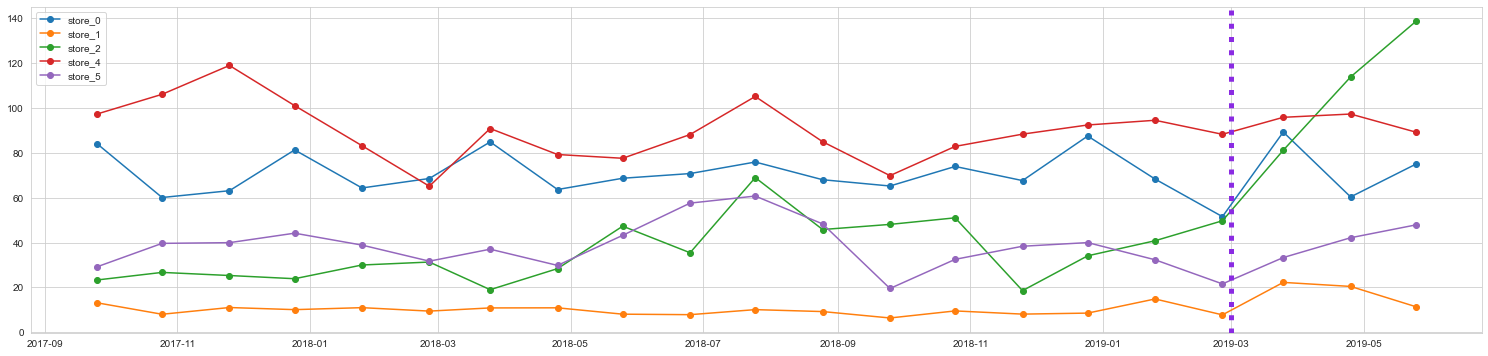

In [97]:
store_plot(monthset, 0,5)

In [84]:
store_plotly(monthset, 0 , 5)